In [2]:
#RUN THIS BEFORE USING
%reset
%matplotlib inline
import network_modules as nm
import graph_measures as gm
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import networkx as nx
import collections
import scipy.signal as sig

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [262]:
slider1 = widgets.IntSlider(min=50, max=5000, step=50, value= 50, description = 'n')
slider2 = widgets.IntSlider(min=1, max=10, value=1, description = 'm')
slider3 = widgets.FloatSlider(min=0, max=10, value=1, description = 'a')
slider4 = widgets.FloatSlider(min=0, max=2*np.pi, value=0, description = 'b')
slider5 = widgets.FloatSlider(min=0, max=1, value=0, description = 'c')
slider6 = widgets.FloatSlider(min=0, max=10, value=1, description = 'K')
display(slider1, slider2, slider3, slider4, slider5,slider6)

In [302]:
n = slider1.value
m = slider2.value
print('n = ',n)
print('m = ',m)
G = nx.barabasi_albert_graph(n, m)

n =  50
m =  2


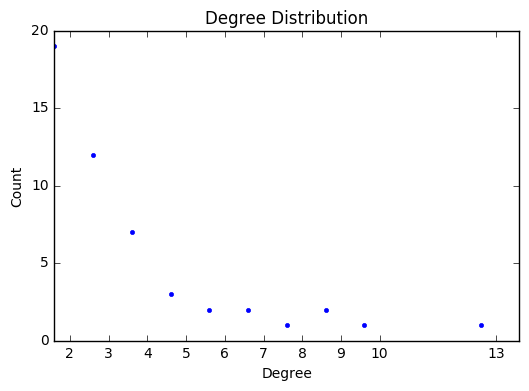

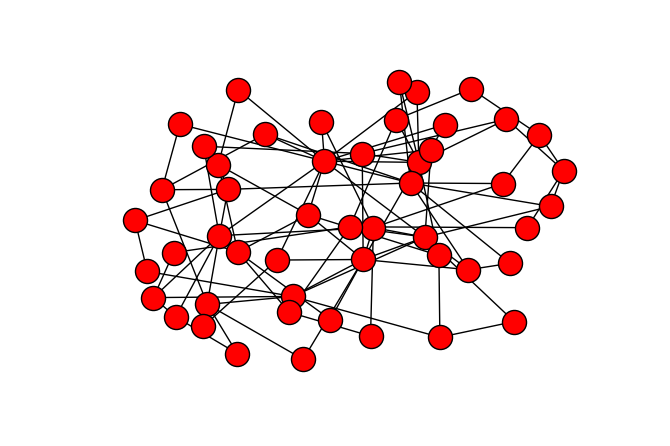

In [304]:
gm.degree_distribution(G)

C:\Users\Rohit\Documents\Research\DBS Summer 2017\NetworkModels\network_modules.py:75: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self.M == None:


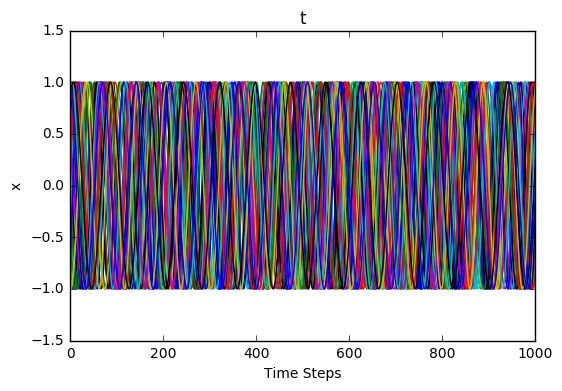

In [283]:
#Parameter Initialization

distributions = [(n,0,2*np.pi,'uniform'),(n,10,2,'normal')]
states = nm.create_vec_states(distributions)
z = np.cos(states[:,0]) + 1j * np.sin(states[:,0])
w = 1j * states[:,1]
x = [[a,b] for a,b in zip(z,w)]

def currynode(w):
    def node(x):   #node function
        return np.array([1j * x[0] * w + x[0]*(1-abs(x[0])),0*1j]) # apply limit cycle term to keep in a circle
    return node

h = [currynode(w) for w in states[:,1]]

def f(x,y): #coupling function
    a = slider3.value
    b = slider4.value
    c = slider5.value
    K = slider6.value
    phi = np.angle(y[0])-np.angle(x[0])
    return np.array([1j * x[0] * complex(K*(np.sin(a*phi+b)+c),0),0*1j])

M = np.identity(n) #Measurement Matrix
N = 0 #Noise Variance

oscillator = nm.nmodel(G,x,h,f,M,N,dt=.01)
oscillator.run(10)
nm.state_course(np.real(nm.reduce_state(0,oscillator.x)))

C:\Users\Rohit\Anaconda3\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


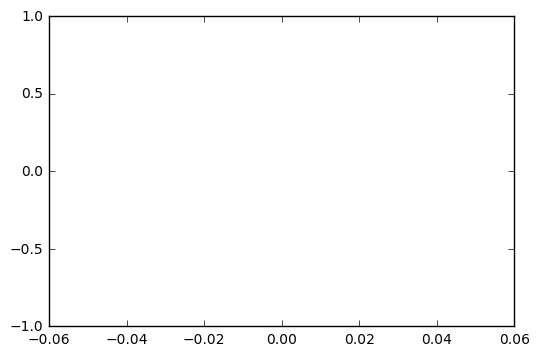

[-1.]


In [3]:
def frange(start, stop, step):  
    i = start
    while i < stop:
        yield i
        i += step
        
@interact(off = (0.0,2*np.pi))
def f(off):
    x = np.array([np.cos(x) + 1j*np.sin(x) for x in frange(0,4*np.pi,.1)])
    y = np.array([np.cos(x + off) + 1j*np.sin(x + off) for x in frange(0,4*np.pi,.1)])
    plt.figure()
    plt.plot(np.array(x)[0])
    plt.plot(np.array(y)[0])
    plt.show()
    print(gm.correlation(x,y))
    

In [ ]:
#f, t, s = sig.spectrogram(signal, fs = 1000, window, nperseg, noverlap, nfft)
#f, Pxx = sig.welch(signal, fs = 1000, window, nperseg, noverlap, nfft)
#import pywt
#cA, cD = pywt.dwt([1, 2, 3, 4], 'db1') - Direct Wavelet Transform

In [ ]:
def create_random_matrix(n,p):
    A = np.zeros((n,n))
    for i in range(n):
        A[i,i] = 0
        for j in range(i+1,n):
            if random() < p:
                A[i,j] = 1
                A[j,i] = 1
    return A
n = 5
N = 10000
d = []
for m in range(N):
    A = create_random_matrix(n,.5)
    B = create_random_matrix(n,.5)
    d.append(sum(sum(A))/n**2)
plt.figure()
plt.hist(d,100)
plt.xlim(0,1)
plt.show()

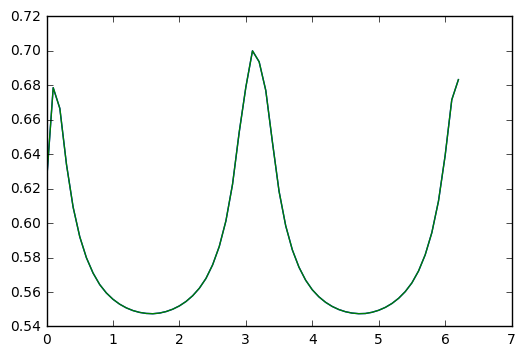

In [217]:
import module_main as mm
def offset_sinusoid(off,compare):
    x = np.array([np.cos(x) + 1j*np.sin(x) for x in frange(0,4*np.pi,.1)])
    y = np.array([np.cos(x + off) + 1j*np.sin(x + off) for x in frange(0,4*np.pi,.1)])
    X = np.stack((x,y),0)
    return compare(X)
diff = []
for off in frange(0,2*np.pi,.1):
    diff.append(offset_sinusoid(off,PDC_func))
plt.figure()
phase = [x for x in frange(0,2*np.pi,.1)] 
plt.plot(phase,diff)
diff = []
for off in frange(0,2*np.pi,.1):
    diff.append(offset_sinusoid(off,DTF_func))
plt.plot(phase,diff)
plt.show()

In [216]:
def DTF_func(X):
    X = np.real(X) 
    p = 2
    A = gm.MVAR_fit(X,p)
    P, freq = gm.DTF(A)
    return np.mean(np.mean(P))
def PDC_func(X):
    X = np.real(X) 
    p = 2
    A = gm.MVAR_fit(X,p)
    P, freq = gm.PDC(A)
    return np.mean(np.mean(P))

C:\Users\Rohit\Documents\Research\DBS Summer 2017\NetworkModels\network_modules.py:75: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self.M == None:


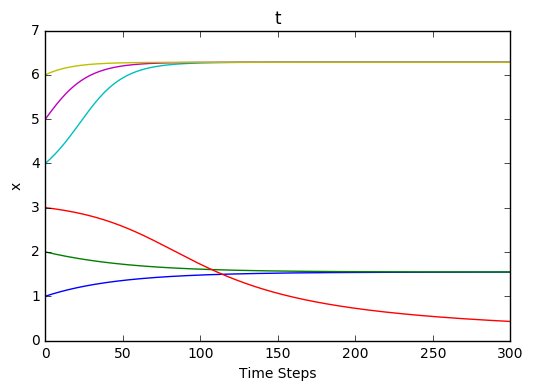

[[ 0.          0.73583504  0.01747003  0.06637825  0.09282743  0.47996443]
 [ 0.71988187  0.          0.01826628  0.05229331  0.09237236  0.4758673 ]
 [ 0.72173667  0.73168773  0.          0.03755365  0.07207301  0.39891453]
 [ 0.71876994  0.67627631  0.02917045  0.          0.32012101  0.49856241]
 [ 0.71840669  0.65846421  0.04602003  0.24030417  0.          0.86646994]
 [ 0.7183213   0.65817498  0.01091696  0.04801846  0.24435298  0.        ]]


In [184]:
coherence = lambda X,Y: max(sig.coherence(X,Y)[1])
nodes = [0,1,2,3,4,5]
Graphh = nx.Graph()
Graphh.add_nodes_from(nodes)
Graphh.add_edges_from([(0,1)])
def h(x):
    return -x*np.sin(x)
def f(x,y):
    return y
Matrix = np.identity(6)
Noise = 0
state = [[1],[2],[3],[4],[5],[6]]
tester = nm.nmodel(Graphh,state,h,f,Matrix,Noise,dt=.01)
tester.run(3)
nm.state_course(tester.x[:,0,:])
#print(gm.cross_func(tester.x[:,0,:], kernel_TE))
print(mm.DTF_func(tester.x[:,0,:]))
#print(gm.partial_method(tester.x[:,0,:],gm.r2))

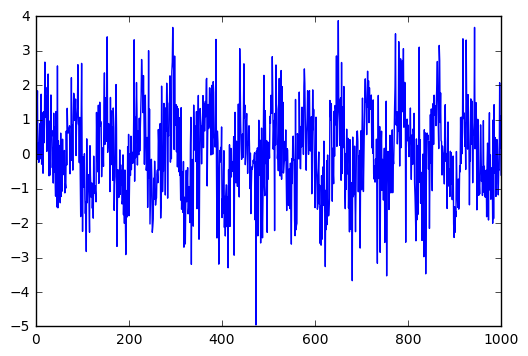

In [301]:
scale = 1
noisy_x = oscillator.x + np.random.normal(0,scale,oscillator.x.shape) + \
1j * np.random.normal(0,scale,oscillator.x.shape)
#plt.plot(np.real(oscillator.x[0,0,:]))
plt.plot(np.real(noisy_x[0,0,:]))
plt.show()
add_noise = lambda X,dev = X + np.random.normal(0,dev,X.shape) + 1j*np.random.normal(0,dev,X.shape)
1j


(22, 25, 25)


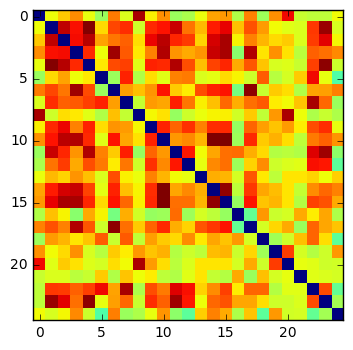

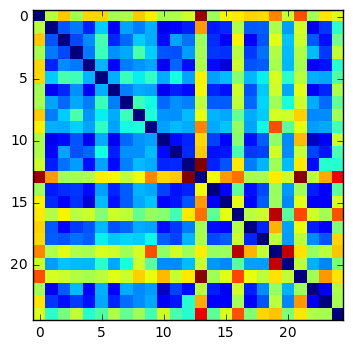

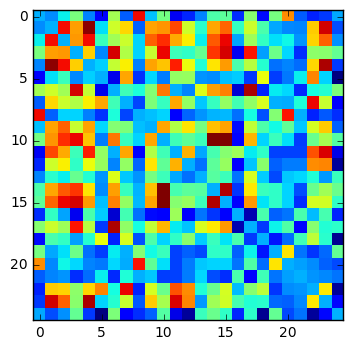

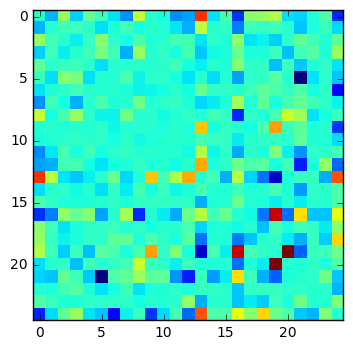

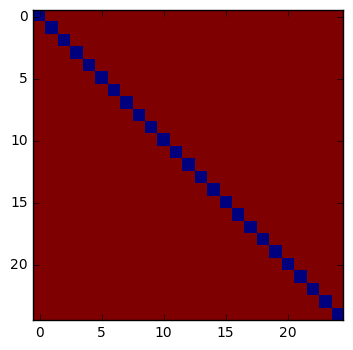

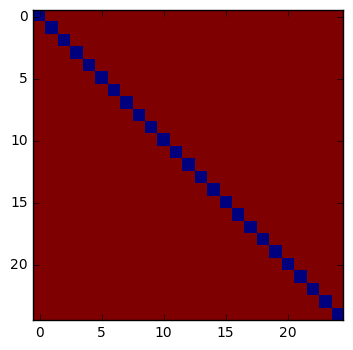

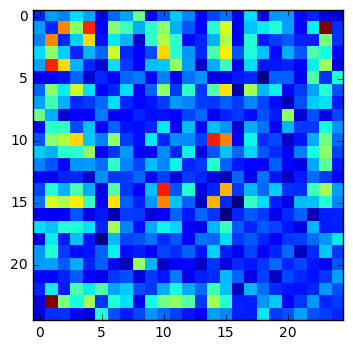

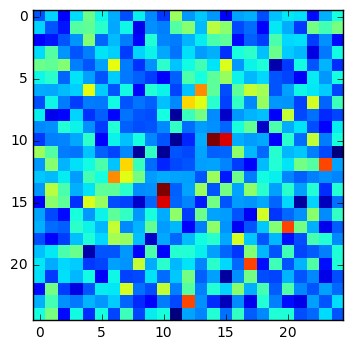

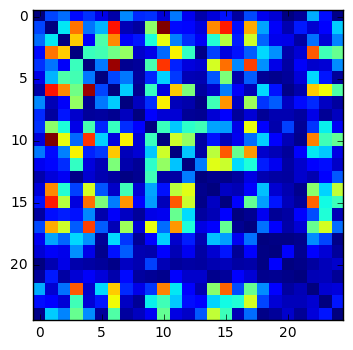

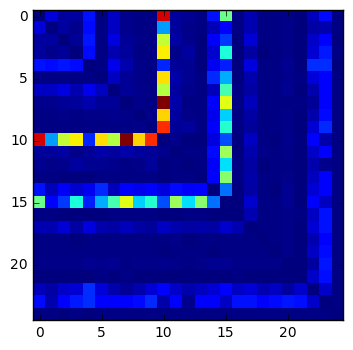

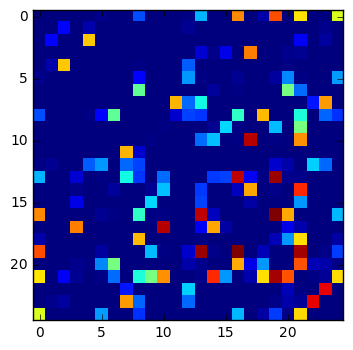

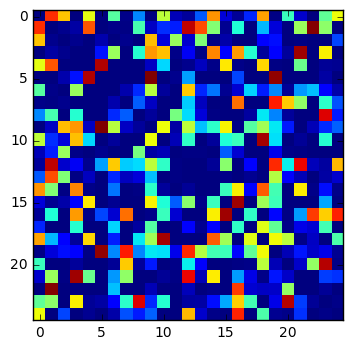

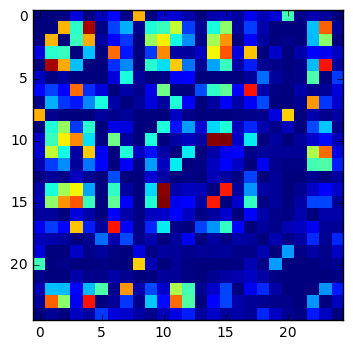

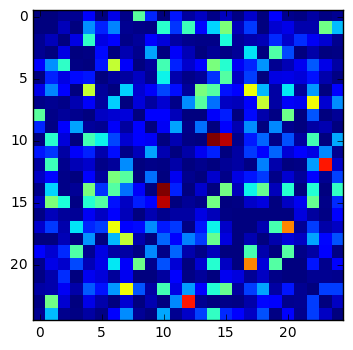

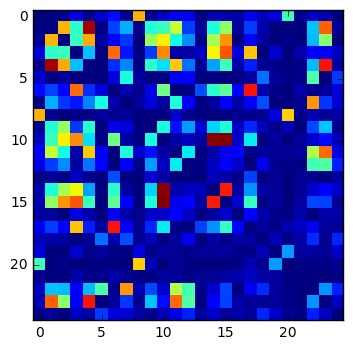

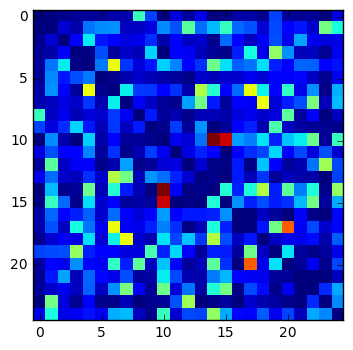

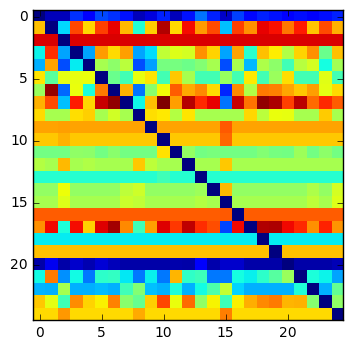

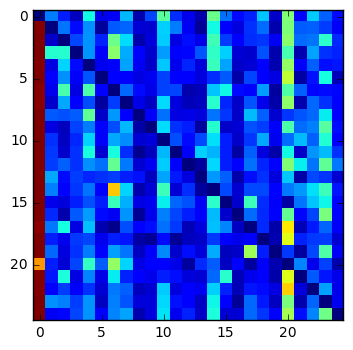

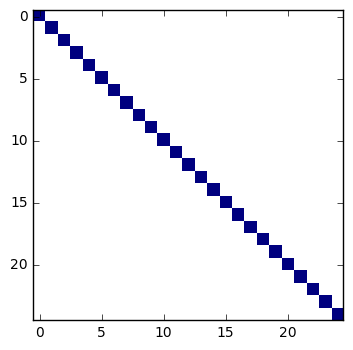

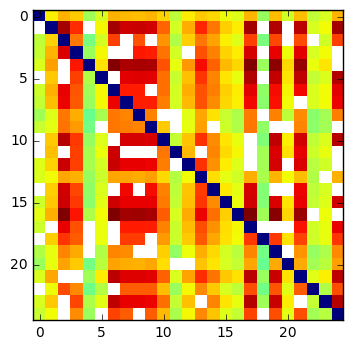

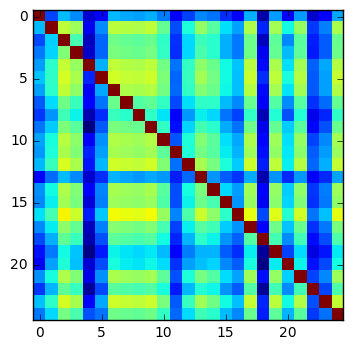

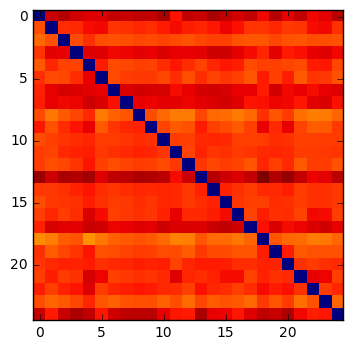

In [7]:
import pickle
with open('measure_normal' , 'rb') as pickle_data:
    measure_normal = np.array(pickle.load(pickle_data))
    x = measure_normal[0]
    print(x.shape)
    plt.figure()
    for mat in x:
        plt.imshow(mat, interpolation= "nearest")
        plt.show()